# 1.Load data

In [ ]:
import pandas as pd

In [ ]:
!pip install datasets
from datasets import load_dataset
dataset = load_dataset(
   'wikiann', 'en')

     |████████████████████████████████| 306 kB 30.4 MB/s 
     |████████████████████████████████| 1.1 MB 66.7 MB/s 
     |████████████████████████████████| 133 kB 82.0 MB/s 
     |████████████████████████████████| 67 kB 7.9 MB/s 
     |████████████████████████████████| 243 kB 78.0 MB/s 
     |████████████████████████████████| 192 kB 76.5 MB/s 
     |████████████████████████████████| 271 kB 77.8 MB/s 
     |████████████████████████████████| 160 kB 76.6 MB/s 


Downloading:   0%|          | 0.00/3.94k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/en/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

In [ ]:
TagsIndex =[
  "O",
  "B-PER",
  "I-PER",
  "B-ORG",
  "I-ORG",
  "B-LOC",
  "I-LOC"
]

Words = []
Tags = []
sentences = []
datasetTkn = dataset['train']['tokens']
datasetTgs = dataset['train']['ner_tags']
c = 0

for tokens,tags in list(zip(datasetTkn,datasetTgs)):
   c += 1
   for token,tag in list(zip(tokens,tags)):
        Words.append(token)
        Tags.append(TagsIndex[tag])
        sentences.append('Sentence: '+str(c))


dataTrain = pd.DataFrame(list(zip(sentences,Words, Tags)),
               columns =['Sentence #','Word', 'Tag'])

In [ ]:
TagsIndex = [
  "O",
  "B-PER",
  "I-PER",
  "B-ORG",
  "I-ORG",
  "B-LOC",
  "I-LOC"
]

Words = []
Tags = []
sentences = []
datasetTkn = dataset['test']['tokens']
datasetTgs = dataset['test']['ner_tags']
c = 0

for tokens,tags in list(zip(datasetTkn,datasetTgs)):
   c += 1
   for token,tag in list(zip(tokens,tags)):
        Words.append(token)
        Tags.append(TagsIndex[tag])
        sentences.append('Sentence: '+str(c))


dataTest = pd.DataFrame(list(zip(sentences,Words, Tags)),
               columns =['Sentence #','Word', 'Tag'])

dataTest.size

240978

In [ ]:
TagsIndex = [
  "O",
  "B-PER",
  "I-PER",
  "B-ORG",
  "I-ORG",
  "B-LOC",
  "I-LOC"
]

Words = []
Tags = []
sentences = []
datasetTkn = dataset['validation']['tokens']
datasetTgs = dataset['validation']['ner_tags']
c = 0

for tokens,tags in list(zip(datasetTkn,datasetTgs)):
   c += 1
   for token,tag in list(zip(tokens,tags)):
        Words.append(token)
        Tags.append(TagsIndex[tag])
        sentences.append('Sentence: '+str(c))


dataValidation = pd.DataFrame(list(zip(sentences,Words, Tags)),
               columns =['Sentence #','Word', 'Tag'])

dataTest.size

240978

In [ ]:
data = [dataTest, dataTrain,dataValidation]
data = pd.concat(data)
data.size
data.head(100)

,Sentence #,Word,Tag
0,Sentence: 1,Shortly,O
1,Sentence: 1,afterward,O
2,Sentence: 1,",",O
3,Sentence: 1,an,O
4,Sentence: 1,encouraging,O
...,...,...,...
95,Sentence: 11,",",O
96,Sentence: 11,Roath,B-LOC
97,Sentence: 11,",",I-LOC
98,Sentence: 11,Cardiff,I-LOC


We can see that the sentences are broken into tokens in the column 'Word'. The column 'sentence #' displays the sentence number once and then prints NaN till the next sentence begins.

## 2. Extract mappings required for the neural network
To train a neural network, we will use two mappings as given below. The neural network will only take integers as input. So lets convert all the unique tokens in the corpus to its respective index.
- {token} to {token id}: address the row in embeddings matrix for the current token.
- {tag} to {tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.7.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install plotly

In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data["Tag"].values))
num_tags = len(tags)

import plotly.express as px

fig = px.histogram(data[~data.Tag.str.contains("OUT")], x="Tag",color="Tag")
fig.show()
print(tags)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import tqdm
def sentence_integrate(data):
  agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()
  
sentences=sentence_integrate(data)
  
sentences[0]

[('Shortly', 'O'),
 ('afterward', 'O'),
 (',', 'O'),
 ('an', 'O'),
 ('encouraging', 'O'),
 ('response', 'O'),
 ('influenced', 'O'),
 ('him', 'O'),
 ('to', 'O'),
 ('go', 'O'),
 ('to', 'O'),
 ('India', 'B-LOC'),
 (';', 'O'),
 ('he', 'O'),
 ('arrived', 'O'),
 ('at', 'O'),
 ('Adyar', 'B-LOC'),
 ('in', 'O'),
 ('1884', 'O'),
 ('.', 'O'),
 ('R.H.', 'B-ORG'),
 ('Saunders', 'I-ORG'),
 ('(', 'O'),
 ('St.', 'B-ORG'),
 ('Lawrence', 'I-ORG'),
 ('River', 'I-ORG'),
 (')', 'O'),
 ('(', 'O'),
 ('968', 'O'),
 ('MW', 'O'),
 (')', 'O'),
 ('Sioux', 'B-ORG'),
 ('Falls', 'I-ORG'),
 ('Arena', 'I-ORG'),
 ('(', 'O'),
 ('Sioux', 'B-LOC'),
 ('Falls', 'I-LOC'),
 (',', 'I-LOC'),
 ('South', 'I-LOC'),
 ('Dakota', 'I-LOC'),
 (')', 'O')]

## 3. Transform columns to extract sequential data
Next, lets fill NaN in 'sentence #' column using method ffill in fillna. Thereafter groupby on the sentence column to get a list of tokens and tags for each sentence.

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

print(word2idx)


{'Domicó': 1, 'Xena': 2, '1610': 3, 'Karamanlis': 4, 'Phantom': 5, 'capable': 6, 'Mantova': 7, 'Zombie': 8, '1715': 9, 'hemilasius': 10, 'Beier': 11, 'Jagadguru': 12, 'Quarters': 13, 'Maverick': 14, 'INXS': 15, '1954-BC': 16, '*1929': 17, 'Newsweeklies': 18, '*Registrar': 19, 'Bhasi': 20, 'Rhiannon': 21, 'British–Dutch': 22, 'Medvedev': 23, 'Red-tailed': 24, 'Rockefeller': 25, '280': 26, 'Warburton': 27, 'McNamara': 28, 'Stefanie': 29, '56006': 30, '«Staraya': 31, 'Murrow': 32, 'A.J.': 33, 'Patriots': 34, '*ALLESTONE': 35, 'Proodeftiki': 36, 'Virtus': 37, 'trophies': 38, 'Castellammare': 39, '*1923': 40, 'Flame': 41, 'Haddon': 42, 'Contepomi': 43, 'Limpele': 44, 'Depot': 45, '[[May': 46, 'Donaspastus': 47, 'Emergency': 48, 'update': 49, 'Amravati': 50, '2006-2008': 51, 'Babban': 52, 'Rezizativbegleiter': 53, 'Astyr': 54, 'Ramphastos': 55, 'Greek-Catholic': 56, 'Cecil': 57, 'Ružomberok': 58, 'syncentra': 59, 'mathematician': 60, '57': 61, 'ruficapilla': 62, 'Shimao': 63, 'Braithwaite': 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

## 4. Pad sequences and split the dataset into train, test
Padding: The LSTM layers accept sequences of same length only. Therefore we will want to transform our list of token_sequences ('Word_idx') which is lists of integers into a matrix of shape (token_sequences, max_len). We can use any length as max_len. In this project we will be using length of the longest sequence as max_len. The sequences that are shorter than max_len are padded with a specified value at the end.
Import required packages

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
#split into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#build model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow import keras

model = keras.Sequential()
model.add(InputLayer((max_len)))
model.add(Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add( Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))

#model summary
model.summary()

#show model plot
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

#compile model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            2733550   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
Total params: 2,854,350
Trainable params: 2,854,350
Non-trainable params: 0
_________________________________________________________________


In [ ]:
!pip install livelossplot

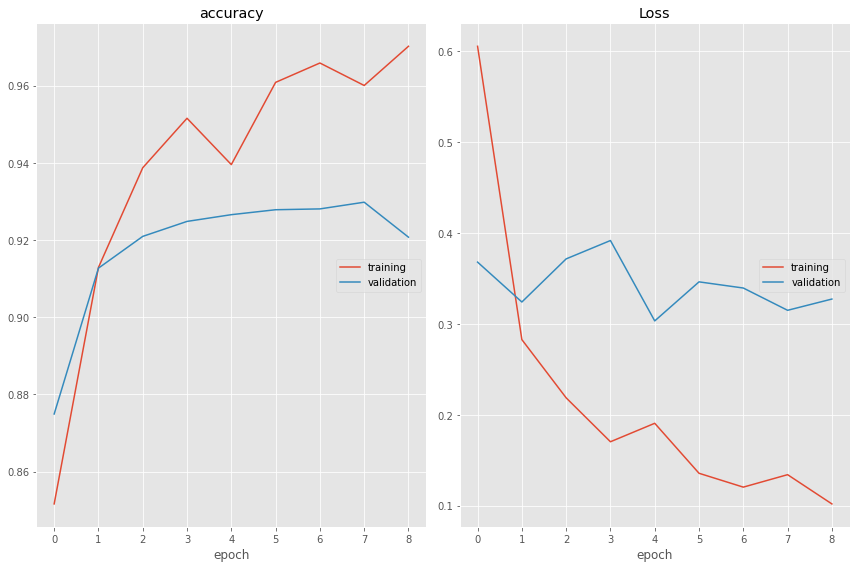

accuracy
	training         	 (min:    0.852, max:    0.970, cur:    0.970)
	validation       	 (min:    0.875, max:    0.930, cur:    0.921)
Loss
	training         	 (min:    0.102, max:    0.605, cur:    0.102)
	validation       	 (min:    0.303, max:    0.392, cur:    0.327)

Epoch 00009: val_loss did not improve from 0.30328
500/500 [==============================] - 83s 165ms/step - loss: 0.1019 - accuracy: 0.9702 - val_loss: 0.3273 - val_accuracy: 0.9207


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

logdir="log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping,tensorboard_callback]


history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=10,
    callbacks=callbacks,
    verbose=1
    
)

#Apply TensorBoard to check the detailed structure and performance
#%load_ext tensorboard

#%tensorboard --logdir log

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

i = np.random.randint(0, x_test.shape[0])
print("This is sentence:",i)
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_test[i], p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Evaluate on test data
32/32 [==============================] - 1s 31ms/step - loss: 0.3273 - accuracy: 0.9207
test loss: 0.3273237645626068 
test accuracy: 0.920740008354187 
This is sentence: 659
Word           True 	 Pred

------------------------------
From           O	O
the            O	O
,              O	O
54             O	O
or             O	O
20.7           O	O
%              O	O
were           O	O
Roman          B-ORG	B-LOC
Catholic       I-ORG	I-LOC
,              O	I-LOC
while          O	O
147            O	O
or             O	O
56.3           O	O
%              O	O
belonged       O	O
to             O	O
the            O	O
Swiss          B-ORG	B-ORG
Reformed       I-ORG	I-ORG
Church         I-ORG	I-ORG
.              O	I-ORG
Shri           B-ORG	I-ORG
Swaminarayan   I-ORG	I-ORG
Mandir         I-ORG	I-ORG
,              I-ORG	I-ORG
Mumbai         I-ORG	I-ORG
Joseph         B-ORG	B-PER
Fielding       I-ORG	I-ORG
Smith          I-ORG	I-PER
Institute      I-ORG	I-ORG
for            I